In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from mpl_toolkits.mplot3d import Axes3D

# Introduction

http://media.salford-systems.com/video/tutorial/2015/targeted_marketing.pdf

**Problem**: Only about 11% of customers at a Portuguese bank purchased long term deposits. How can the bank increase these numbers? We assume that all term deposits are equivalent in value. 

In [2]:
def to_int(is_true):
    if is_true == 'yes':
        return 1
    else:
        return 0

def weekday_to_int(day):
    dict = {"mon" : 0, "tue" : 1, "wed" : 2, "thu" : 3, "fri" : 4}
    return dict[day]

def month_to_int(month):
    dict = {"jan" : 0, 
            "feb" : 1, 
            "mar" : 2, 
            "apr" : 3, 
            "may" : 4, 
            "jun" : 5, 
            "jul" : 6, 
            "aug" : 7, 
            "sep" : 8, 
            "oct" : 9, 
            "nov" : 10, 
            "dec" : 11 }
    return dict[month]

# need to convert poutcome to a numeric variable
# currently consists of nonexistent, failure, success

def poutcome_to_int(x):
    dict = {"nonexistent" : np.nan, "failure" : 0, "success" : 1}
    return dict[x]
    
need_conversion = {"default" : to_int,
                   "housing" : to_int, 
                   "loan" : to_int,
                   "y" : to_int,
                   "day_of_week" : weekday_to_int,
                   "month" : month_to_int, 
                   "poutcome" : poutcome_to_int}

types = {"age": int, 
         "job" : "category",
         "marital" : "category",
         "education" : "category",
         "contact" : "category"}

df = pd.read_csv("bank-additional-full.csv", sep=';', converters=need_conversion, dtype=types)

age_brackets = ["19-28", "29-38", "39-47", "48-57", "58-67", "68-77", "78+"]
df["age_bracket"] = pd.cut(df.age, 4, labels=["1","2","3","4"])

## Variables

Input variables:
### bank client data
  1. age (numeric)
  2. job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
  3. marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
  4. education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
  5. default: has credit in default? (categorical: "no","yes","unknown")
  6. housing: has housing loan? (categorical: "no","yes","unknown")
  7. loan: has personal loan? (categorical: "no","yes","unknown")


### related with the last contact of the current campaign
  8. contact: contact communication type (categorical: "cellular","telephone") 
  9. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  10. day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
  11. duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
   
### other attributes
  12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  14. previous: number of contacts performed before this campaign and for this client (numeric)
  15. poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

### social and economic context attributes
  16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
  17. cons.price.idx: consumer price index - monthly indicator (numeric)     
  18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
  19. euribor3m: euribor 3 month rate - daily indicator (numeric)
  20. nr.employed: number of employees - quarterly indicator (numeric)
  
  
## notes

  Upon reading in the data, we transformed a few of the columns into a format more suitable for analysis, including:
  * default, housing, loan, poutcome: binary representation (0 or 1)
  * day_of_week: converted string abbreviation (mon, tue) to integers. starting with 0 for "mon"
  * month: similar to above, but with 0 representing "jan" and 11 for "dec" 
  
Certain variables only take on a small number of values, so we converted these fields into category variables:
  * job, marital, education and contact


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 22 columns):
age               41188 non-null int64
job               41188 non-null category
marital           41188 non-null category
education         41188 non-null category
default           41188 non-null int64
housing           41188 non-null int64
loan              41188 non-null int64
contact           41188 non-null category
month             41188 non-null int64
day_of_week       41188 non-null int64
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          5625 non-null float64
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null int64
age_bracket       41188 non-null category
dtypes:

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_bracket
0,56,housemaid,married,basic.4y,0,0,0,telephone,4,0,...,999,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0,2
1,57,services,married,high.school,0,0,0,telephone,4,0,...,999,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0,2
2,37,services,married,high.school,0,1,0,telephone,4,0,...,999,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0,1
3,40,admin.,married,basic.6y,0,0,0,telephone,4,0,...,999,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0,2
4,56,services,married,high.school,0,0,1,telephone,4,0,...,999,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0,2


In [3]:
df.describe(include='all')

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_bracket
count,41188.00000,41188,41188,41188,41188.000000,41188.000000,41188.000000,41188,41188.000000,41188.000000,...,41188.000000,41188.000000,5625.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188
unique,NaN,12,4,8,NaN,NaN,NaN,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
top,NaN,admin.,married,university.degree,NaN,NaN,NaN,cellular,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
freq,NaN,10422,24928,12168,NaN,NaN,NaN,26144,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19768
mean,40.02406,NaN,NaN,NaN,0.000073,0.523842,0.151695,NaN,5.607896,1.979581,...,962.475454,0.172963,0.244089,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654,NaN
std,10.42125,NaN,NaN,NaN,0.008534,0.499437,0.358729,NaN,2.040998,1.411514,...,186.910907,0.494901,0.429584,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173,NaN
min,17.00000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,2.000000,0.000000,...,0.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,NaN
25%,32.00000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,4.000000,1.000000,...,999.000000,0.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000,NaN
50%,38.00000,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN,5.000000,2.000000,...,999.000000,0.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000,NaN
75%,47.00000,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN,7.000000,3.000000,...,999.000000,0.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000,NaN


## Summary of Data

Just to get a brief overview of our data, here is what the typical customer looks like:
  * 40 years old
  * Married
  * Works in the admin field
  * Hold a university degree 
  * Has a housing loan with the bank offering the deposit
  * Reached via cellular phone

Stats on the current campaign:
  * Primarily conducted during the summer months, particularly April
  * Calls were made nearly uniform during the week (day)
  * Calls lasted an average of 258 seconds (4.3 minutes)
  * Each customer was contacted an average of 2.5 times during this campaign

Stats on previous campaign(s):
  * After being contacted (for a previous campaign), an average of 962 days passed
  * During the last campaign, 1 in every 5.8 customers were contacted at least once
  * Every customer was contacted at least once during the current campaign
  * 24.4% of customers purchased a long-term deposit during the previous campaign
  * 86.3% of all customers were not contacted at all during the previous campaign
    * Which means only 13.6% of all customers were contacted at least once during both campaigns

The standard deviation of the social-economic variables are high (relative to it's mean). 

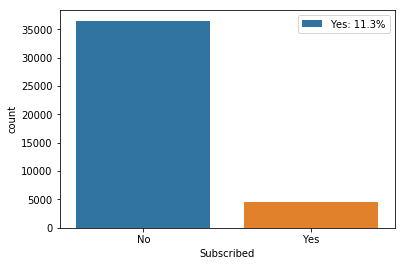

In [18]:
ax = sns.countplot(df.y)
plt.xticks([0,1],["No", "Yes"])
ax.set_xlabel("Subscribed")
plt.legend(["Yes: {}%".format(round(100*mu,1))])

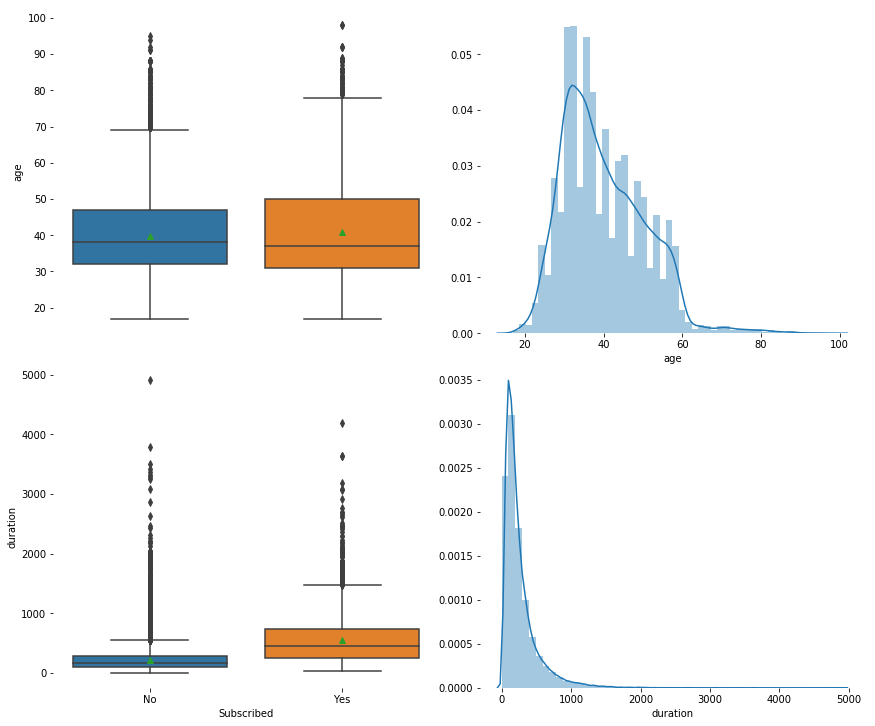

In [114]:
#Creates four polar axes, and accesses them through the returned array
# how do you control the figure size?
fig, axes = plt.subplots(2, 2)
fig.set_figwidth(12)
fig.set_figheight(10)
fig.tight_layout()
sns.despine(fig=fig, left=True, bottom=True)
sns.boxplot(x="y", y="age", data=df, ax=axes[0,0], showmeans=True)
axes[0,0].set(xlabel = "")
axes[0,0].set(xticks = [])
# so not much difference in age by subscribe type
sns.boxplot(x="y", y="duration", data=df, ax=axes[1,0], showmeans=True)
axes[1,0].set(xlabel = "Subscribed")
axes[1,0].set(xticklabels = ["No", "Yes"])
sns.distplot(df.age, ax=axes[0,1])
sns.distplot(df.duration, ax=axes[1,1])

## Age

In [50]:
df.groupby('age_bracket').mean()

,age,default,housing,loan,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age_bracket,,,,,,,,,,,,,,,,,
1,31.428622,0.000051,0.527722,0.156516,5.530504,2.009915,258.925941,2.532325,960.476983,0.185502,0.239945,-0.033276,93.545186,-40.878915,3.474050,5161.977529,0.120397
2,46.126850,0.000104,0.519648,0.149677,5.637221,1.951636,256.489004,2.624922,973.745205,0.136492,0.203695,0.309641,93.627169,-40.367417,3.894141,5178.534918,0.086565
3,61.902989,0.000000,0.519843,0.121999,6.027438,1.956394,267.518373,2.440960,895.352768,0.341989,0.395538,-0.724547,93.421995,-38.444390,2.735225,5120.926948,0.245468
4,82.743455,0.000000,0.586387,0.172775,6.188482,1.895288,273.712042,1.811518,754.408377,0.732984,0.542169,-2.262304,93.198037,-37.129319,0.917921,5028.080628,0.513089


              size      mean
age_bracket                 
1            19768  0.120397
2            19188  0.086565
3             2041  0.245468
4              191  0.513089


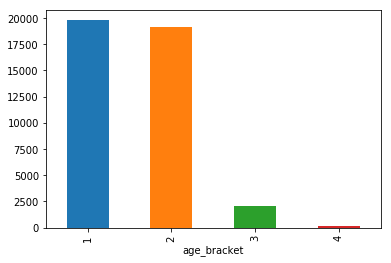

In [7]:
# how many in each age bracket?
print(df.groupby('age_bracket').y.aggregate(["size","mean"]))
df.groupby('age_bracket').size().plot.bar()

So older customers are called earlier in the week and have a much higher purchase rate than younger customers (51.3% to 12%), however the rate at which they previously purchased a long term deposit is much higher (54.2% to 23.9%). It is important to note that older customers were contacted significantly more prior to this campaign, but significantly less during the current campaign and with more time passing in between last campaign and this, possibly suggesting that these customers were engaged more consistently than younger customers, requiring less "convincing." **Bottom line**: older customers appear to be better candidates to contact. 

Because the age classes are quite unbalanced, a 2% increase in age group 2 results in 384 conversions, or a little more than twice as many people in all of age group 4. Therefore, time might be better spent focusing on the larger groups. The fairly high rate of previously purchasing a long term deposit and subscribing during the current campaign may suggest that there is very little turnover among these customers. 

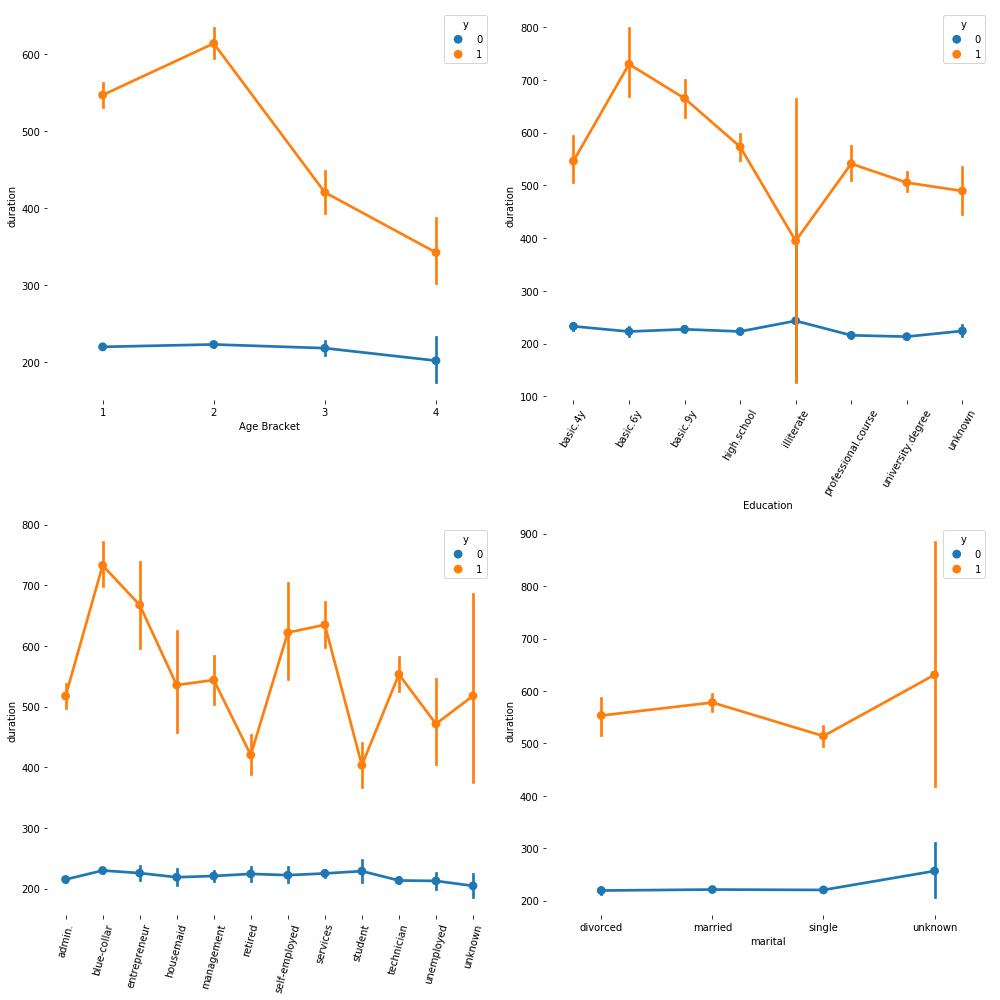

In [20]:
# lets put 4 pointplots on one figure
fig, axes = plt.subplots(2, 2)
fig.set_figwidth(14)
fig.set_figheight(14)

sns.despine(fig=fig, left=True, bottom=True)
# pointplot of duration by age bracket
sns.pointplot('age_bracket', "duration", hue="y", data=df, ax=axes[0,0])
axes[0,0].set_xlabel("Age Bracket")
sns.pointplot('education', 'duration', hue='y', data=df, ax=axes[0,1])
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=60)
axes[0,1].set_xlabel("Education")
sns.pointplot('job', 'duration', hue='y', data = df, ax=axes[1,0])
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=75)
axes[1,0].set_xlabel("")
sns.pointplot('marital', 'duration', hue='y', data=df, ax=axes[1,1])
fig.tight_layout()

## Job

In [51]:
df.groupby('job').mean()

,age,default,housing,loan,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
job,,,,,,,,,,,,,,,,,
admin.,38.187296,0.000000,0.533391,0.164076,5.776243,1.992420,254.312128,2.623489,954.319229,0.189023,0.281764,0.015563,93.534054,-40.245433,3.550274,5164.125350,0.129726
blue-collar,39.555760,0.000000,0.508969,0.147612,5.088286,1.998811,264.542360,2.558461,985.160363,0.122542,0.118408,0.248995,93.656656,-41.375816,3.771996,5175.615150,0.068943
entrepreneur,41.723214,0.000000,0.535027,0.141484,5.796703,1.969780,263.267857,2.535714,981.267170,0.138736,0.139665,0.158723,93.605372,-41.283654,3.791120,5176.313530,0.085165
housemaid,45.500000,0.000000,0.509434,0.145283,5.805660,1.875472,250.454717,2.639623,960.579245,0.137736,0.339286,0.433396,93.676576,-39.495283,4.009645,5179.529623,0.100000
management,42.362859,0.000000,0.509576,0.150137,5.994186,1.927497,257.058140,2.476060,962.647059,0.185021,0.223005,-0.012688,93.522755,-40.489466,3.611316,5166.650513,0.112175
retired,62.027326,0.000000,0.518605,0.139535,6.019767,1.947674,273.712209,2.476744,897.936047,0.327326,0.407216,-0.698314,93.430786,-38.573081,2.770066,5122.262151,0.252326
self-employed,39.949331,0.000000,0.520760,0.137227,5.793103,2.013371,264.142153,2.660802,976.621393,0.143561,0.171429,0.094159,93.559982,-40.488107,3.689376,5170.674384,0.104856
services,37.926430,0.000000,0.516503,0.151424,5.222474,1.966490,258.398085,2.587805,979.974049,0.154951,0.135135,0.175359,93.634659,-41.290048,3.699187,5171.600126,0.081381
student,25.894857,0.000000,0.538286,0.162286,5.597714,1.994286,283.683429,2.104000,840.217143,0.524571,0.419929,-1.408000,93.331613,-40.187543,1.884224,5085.939086,0.314286


In [10]:
df.groupby('job').size()

job
admin.           10422
blue-collar       9254
entrepreneur      1456
housemaid         1060
management        2924
retired           1720
self-employed     1421
services          3969
student            875
technician        6743
unemployed        1014
unknown            330
dtype: int64

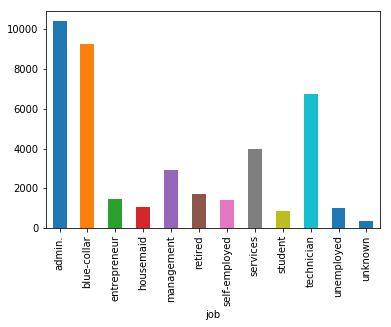

In [23]:
df.groupby("job").size().plot.bar()

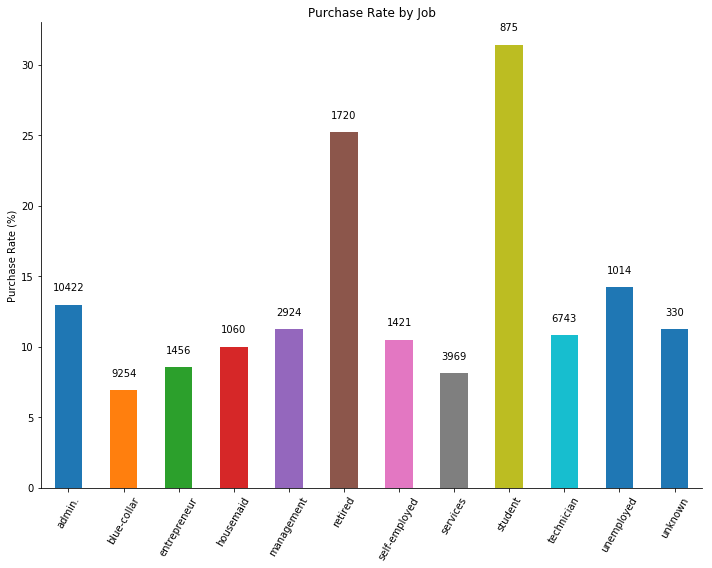

In [19]:
jobs = df.groupby("job").y.aggregate(["size", "mean"])

# want to show a boxplot of rate by job
# it would be nice to add the total group size above each bar
plt.figure(figsize=(10,8))
plt.title("Purchase Rate by Job")
ax = np.multiply(jobs["mean"],100).plot.bar()
plt.ylabel("Purchase Rate (%)")
plt.xticks(rotation=60)
plt.xlabel("")
counter = 0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., 
            height + 1,jobs["size"][counter],
            ha="center")
    counter+=1
plt.tight_layout()
sns.despine()
plt.show()

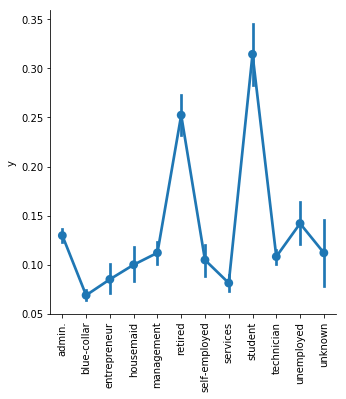

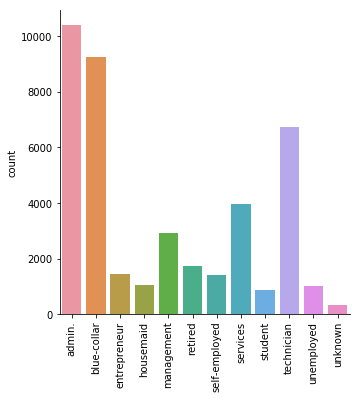

<Figure size 432x288 with 0 Axes>

In [21]:
daily = df.groupby(["job", "day_of_week"]).mean()
sns.catplot('job','y',data=df, kind="point")
plt.xlabel("")
plt.xticks(rotation=90)
sns.catplot('job', data=df, kind="count")
plt.xticks(rotation=90)
plt.xlabel("")
plt.show()
plt.clf()

[Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11')]

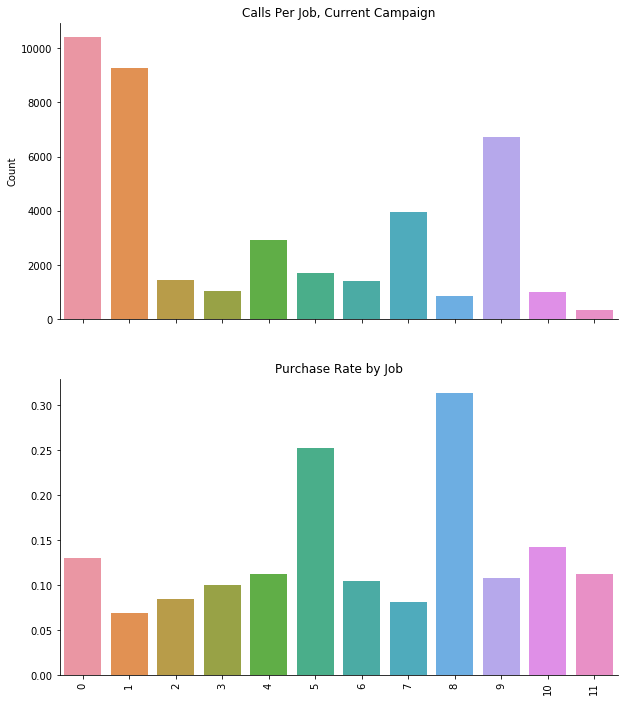

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.set_figheight(12)
fig.set_figwidth(10)
jobs = df.groupby("job").y.aggregate(["size", "mean"])
jobs.reset_index(inplace=True)
sns.barplot(x=jobs.index, y=jobs["size"].values, ax=ax1)
ax1.set_title("Calls Per Job, Current Campaign")
sns.despine()
ax1.set_xlabel("")
ax1.set_ylabel("Count")
sns.barplot(x=jobs.index, y=jobs["mean"].values, ax=ax2)
ax2.set_title("Purchase Rate by Job")
ax2.set_xlabel("")
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)

Housing loans remained relatively similar among jobs, as did personal loans. It is interesting to look at the previous variable (number of contacts performed in the previous campaign), this variable appears to have a positive, linear relationship with the outcome of this campaign. Blue-collar customers had the worst average outcome, as well as the worst previous outcome, so I would minimize calls to this group of customers. Conversely, students had the best subscribe rate, previous rate, and the lowest calls for this campaign. Therefore, it would follow that decreasing the number of calls to those customers holding a blue-collar job and increasing calls to students will increase the overall subscribe rate for this campaign, with significantly less effort. Also notice the nearly 13.7 year gap between the average ages of the two groups; this appears to be anomalous. **Bottom-line:** past history is a fairly good indicator of future purchases when conditioned on the job. Call less blue-collar workers and more retired customers.

So you want to target the retired and student populations, however lets look at their respective sizes. Try to identify factor(s) driving unknown job rates to be relatively high with respect to low number of calls. 

## Duration

In [28]:
df.query("poutcome == 0").groupby("job").duration.mean()

job
admin.           248.280477
blue-collar      243.347630
entrepreneur     228.474026
housemaid        256.716216
management       244.513595
retired          264.386957
self-employed    232.765517
services         256.781250
student          260.650307
technician       249.220065
unemployed       243.585106
unknown          243.388889
Name: duration, dtype: float64

In [29]:
df.query("poutcome == 1").groupby("job").duration.mean()

job
admin.           318.366822
blue-collar      360.420168
entrepreneur     321.400000
housemaid        356.026316
management       331.189474
retired          307.772152
self-employed    338.933333
services         305.542857
student          314.000000
technician       315.592417
unemployed       299.080645
unknown          321.368421
Name: duration, dtype: float64

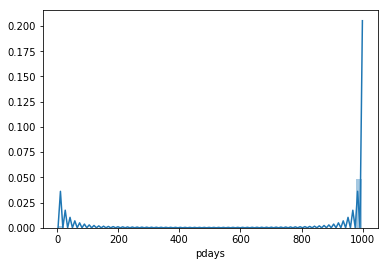

In [32]:
sns.distplot(df.query("poutcome == 0").pdays)

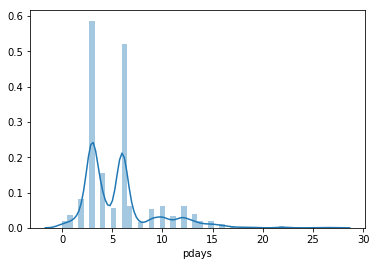

In [33]:
sns.distplot(df.query("poutcome == 1").pdays)

From this we can see that the average duration for those customers who did not purchase was 220.8 regardless of group, and that there was little difference among marital groups, but quite a large fluctuation in duration time when it came to job type and education. When looking at the average duration, by job, for purchase and not purchase calls we notice that:
  1. Did not purchase
    * Blue-collar: 3.8 minutes
    * Unknown: 3.4
    * Retired: 3.7
  2. Purchase
    * Blue-collar: 12.2
    * Student: 6.7
    * Retired: 7

Duration is not known before a call, so if we can predict which customers will stay on the phone longer this will identify customers that have a higher chance of subscribing. So this variable should not be used in a predictive model, instead should be a predicted outcome. 

Customers who previously subscribed spent an average of 29% more time on the phone than those who did not subscribe. Furthermore, 172% more time passed between contacts for customers who previously subscribed versus those customers who did not subscribe. This is a stark difference that should be considered when contacting customers: take the outcome of the previous campaign into account, if a customer purchased last time you do not have to wait as long.

## Previous Campaign

In [35]:
df.query("poutcome == 0").y.mean()

0.1422859830667921

In [36]:
df.query("poutcome == 1").y.mean()

0.651128914785142

65% of those customers who previously subscribed subscribed again, whereas 85% of those customers who did not purchase a long-term deposit during the previous campaign also did not subscribe during this campaign.

## Education

In [52]:
df.groupby('education').mean()

,age,default,housing,loan,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
education,,,,,,,,,,,,,,,,,
basic.4y,47.596504,0.000000,0.503831,0.149425,5.401820,1.941810,264.827826,2.600575,965.704981,0.147031,0.262500,0.215924,93.658309,-40.239871,3.751768,5170.124880,0.102490
basic.6y,40.448953,0.000000,0.506981,0.143979,5.146597,2.009599,264.414485,2.556283,980.368237,0.129145,0.155039,0.231152,93.650062,-41.127880,3.772942,5174.718063,0.082024
basic.9y,39.061208,0.000000,0.521257,0.146071,5.229115,2.001820,261.291811,2.532341,979.133168,0.141439,0.149798,0.159239,93.623399,-41.326749,3.697963,5172.294012,0.078246
high.school,37.998213,0.000105,0.518339,0.151655,5.471046,1.959432,260.886810,2.568576,964.358382,0.185917,0.208068,0.032937,93.584857,-40.940641,3.556157,5164.994735,0.108355
illiterate,48.500000,0.000000,0.555556,0.166667,6.277778,2.388889,276.777778,2.277778,943.833333,0.111111,0.500000,-0.133333,93.317333,-39.950000,3.516556,5171.777778,0.222222
professional.course,40.080107,0.000381,0.541293,0.151249,5.782377,1.981881,252.533855,2.586115,960.765974,0.163075,0.266764,0.173012,93.569864,-40.124108,3.710457,5170.155979,0.113485
university.degree,38.879191,0.000000,0.534517,0.158613,6.003041,1.979536,253.223373,2.563527,951.807692,0.192390,0.300282,-0.028090,93.493466,-39.975805,3.529663,5163.226298,0.137245
unknown,43.481225,0.000000,0.505488,0.139804,5.477759,2.053148,262.390526,2.596187,942.830734,0.226459,0.314815,0.059099,93.658615,-39.877816,3.571098,5159.549509,0.145003


In [55]:
df.groupby('education').size()

education
basic.4y                4176
basic.6y                2292
basic.9y                6045
high.school             9515
illiterate                18
professional.course     5243
university.degree      12168
unknown                 1731
dtype: int64

Strange, it appears the more educated a person is the less likely they will subscribe. This appears to be due to the small sample size of illiterate people compared to the other groups. Ignore this for now. What is basic._Y? Too many questions here so we will not use this information in experimental design.

## Marital status

In [49]:
df.groupby('marital').mean()

,age,default,housing,loan,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
marital,,,,,,,,,,,,,,,,,
divorced,44.899393,0.00000,0.520165,0.146357,5.663487,1.930182,253.790330,2.61340,968.639853,0.168690,0.204437,0.163985,93.606563,-40.707069,3.715603,5170.878643,0.103209
married,42.307165,0.00012,0.519536,0.151356,5.624799,1.977335,257.438623,2.57281,967.247673,0.155608,0.232700,0.183625,93.597367,-40.270659,3.745832,5171.848772,0.101573
single,33.158714,0.00000,0.535183,0.154564,5.551089,2.004063,261.524378,2.53380,949.909578,0.211359,0.276083,-0.167989,93.517300,-40.918698,3.317447,5155.199265,0.140041
unknown,40.275000,0.00000,0.437500,0.150000,5.350000,1.987500,312.725000,3.18750,937.100000,0.275000,0.277778,-0.221250,93.471250,-40.820000,3.313037,5157.393750,0.150000


Interesting to note that married people subscribe significantly less than single customers, who are much younger and are more likely to have subscribed in the past.

## Time: Day of the week

In [53]:
df.groupby("day_of_week").mean()

,age,default,housing,loan,month,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
day_of_week,,,,,,,,,,,,,,,,
0,40.412497,0.000000,0.535941,0.156566,5.519027,246.568358,2.645760,962.852948,0.171012,0.240870,0.026063,93.577108,-40.877790,3.542196,5164.568393,0.099483
1,40.427441,0.000371,0.512485,0.144623,5.685538,260.455995,2.426823,959.715575,0.173053,0.265511,0.128220,93.577088,-40.034227,3.701038,5168.486094,0.117800
2,39.526801,0.000000,0.525449,0.150111,5.694615,265.883206,2.449840,962.859970,0.169044,0.251397,0.166745,93.590225,-40.281387,3.726885,5170.425436,0.116671
3,39.591557,0.000000,0.536240,0.150876,5.672504,265.674591,2.595268,959.501913,0.174417,0.265876,0.058460,93.556380,-40.753323,3.574923,5166.662693,0.121188
4,40.177846,0.000000,0.507091,0.156254,5.463013,252.748818,2.719944,967.793791,0.177463,0.196619,0.032337,93.578735,-40.532260,3.566249,5165.109799,0.108087


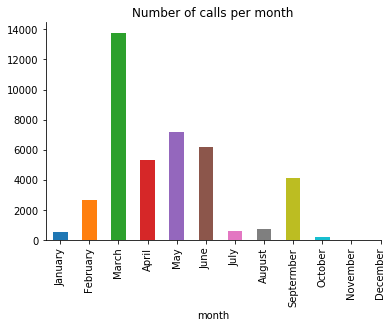

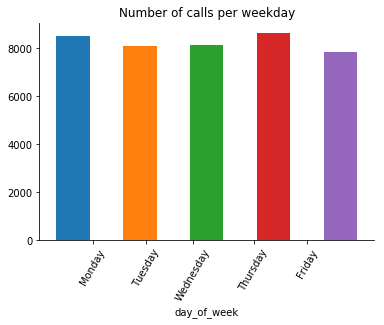

In [24]:
plt.title("Number of calls per month")
months = ["January", "February", "March", "April", 
          "May", "June", "July", "August", "Septermber", 
          "October", "November", "December"]
# the numbers are not right here...off by 1 month
df.groupby("month").size().plot.bar()
sns.despine()
plt.xticks(range(0,12), months, rotation = 90)
plt.show()
plt.title("Number of calls per weekday")
df.groupby("day_of_week").y.size().plot.bar()
plt.xticks([0.3,1.1,1.8,2.7,3.5],["Monday","Tuesday","Wednesday","Thursday","Friday"], rotation = 60)
sns.despine()

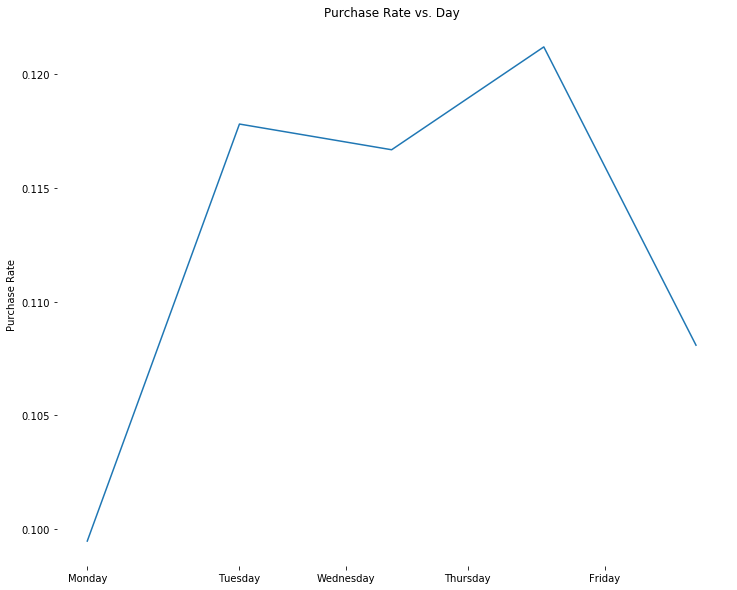

In [25]:
plt.figure(figsize=(12,10))
ax = sns.lineplot(x=range(0,5), y=df.groupby("day_of_week").y.mean().values)
plt.xticks([0,1,1.7,2.5,3.4],["Monday","Tuesday","Wednesday","Thursday","Friday"])
plt.ylabel("Purchase Rate")
plt.title("Purchase Rate vs. Day")
sns.despine(left=True, bottom=True)

Not seeing that big of a difference in outcome conditioned on day of week. On Fridays they called less customers who previously subscribed, however according to campaign more calls for this campaign were made on Fridays. Suggestion: call more customers who previously subscribed on Fridays. Over half of all customers have a house loan with this bank and all were around 40 years old.

So the current campaign looks as if it was mainly conducted during the summer months (April), but calls were made pretty uniformly throughout each week. 

So according to the above plots, we should reduce the total number of calls on Mondays and Fridays, especially to those populations that was less likely to purchase long-term deposits (blue-collar employees).

## Total Calls

Text(0, 0.5, 'Purchase Rate')

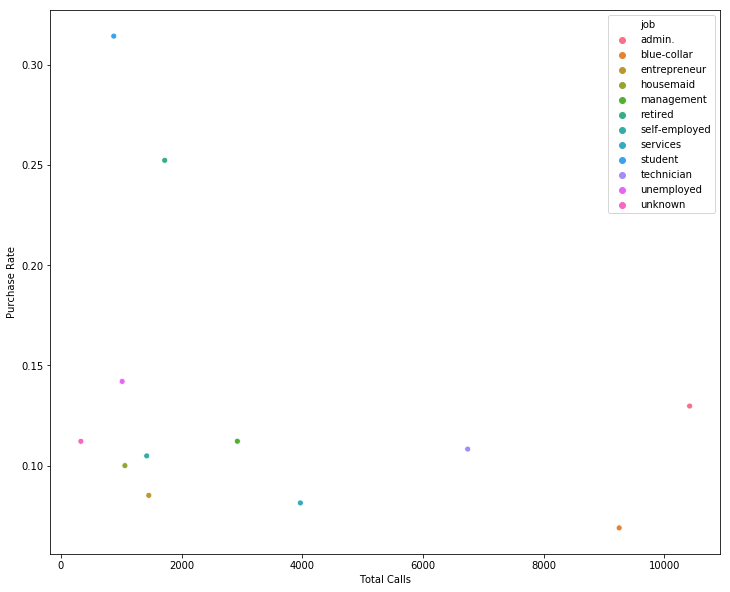

In [115]:
# Here I am trying to plot the number of calls versus the purchase rate, colored by job...
# and the size of the marker corresponding to ratio of that job's mean rate / alll jobs rate
plt.figure(figsize=(12,10))
ax = sns.scatterplot(x=jobs["size"], y=jobs["mean"], hue=jobs.job, sizes=10*(jobs["mean"] / df.y.mean()))
ax.set_xlabel("Total Calls")
ax.set_ylabel("Purchase Rate")

## Correlation

In [26]:
df.corr()["y"]

age               0.030399
default          -0.003041
housing           0.011743
loan             -0.004466
month             0.037187
day_of_week       0.010051
duration          0.405274
campaign         -0.066357
pdays            -0.324914
previous          0.230181
poutcome          0.494368
emp.var.rate     -0.298334
cons.price.idx   -0.136211
cons.conf.idx     0.054878
euribor3m        -0.307771
nr.employed      -0.354678
y                 1.000000
Name: y, dtype: float64

Not surprisingly, current campaign purchase rates are correlated with previous outcomes as well as phone call duration, however it is interesting to see are also correlated with social-economic metrics such as the Euribor rate, employee variation rate and number of employees. The latter two metrics may only be relevant to the bank at hand, and if so it appears that the more stable your work environment is, the more conversions you get. 
The Euro Interbank Offered Rate (Euribor) is a daily reference rate, published by the European Money Markets Institute, based on the averaged interest rates at which Euribor banks offer to lend unsecured funds to other banks in the euro wholesale money market (or interbank market).

# Proposal
Therefore, a simple allocation adjustment should result in more purchases of long-term deposits.
  * Reduce calls to customers who list their job as unknown by about 7.7% (6), call 99 less blue-collar workers (5.4%) and 11 fewer housemaids (4.8%).
  * We see a similar trend on Fridays, this time also for blue-collar employees as well as service and entrepreneur jobs. So decrease calls to blue-collar employees by about 4.1% (73), cut call to service workers by about 3.3% (25) and call ~2.6% less entrepreneurs (7).
  * This equates to making 221 fewer calls (to populations who purchase less on average), or a little over 15 hours. This time can then be distributed among the jobs that are more likely to purchase. If we want to maximize this, we need to consider the average duration required per job as well as their average purchase rate. 
    * unemployed (1014): mean rate of 14.2% with an average duration of 249.4 seconds, call 62 more of these customers.
    * student (875): rate of 31.4%, mean duration of 283.7 seconds, call 52 more of these customers. 
    * retired (1720): rate of 25.2% and a mean duration of 273.7 seconds, call 107 more of these customers. 
  
  